# MAST API Tutorial - Webservice API

This tutorial will demonstrate how to search for observations, download data products, and display the results using the MAST Webservice API.

Full documentation on the webservice API can be found <a href="https://mast.stsci.edu/api/v0/">here.</a>

## Table of Contents

1. [Imports](#Imports)
2. [Building a MAST request](#Building-a-MAST-request)    
3. [Searching for MAST observations](#Searching-for-MAST-observations)
    - [Using the name resolver](#Using-the-name-resolver)
    - [Performing a cone search](#Performing-a-cone-search)
    - [Performing a filtered query](#Performing-a-filtered-query)<br><br>
    
3. [Getting data products associated with one or more observations](#Getting-data-products-associated-with-one-or-more-observations)
4. [Downloading data products](#Downloading-data-products)
5. [Displaying data](#Displaying-data)

## Imports
<div style="text-align: right">[(top)](#MAST-API-Tutorial---Webservice-API)</div>

In [1]:
import sys
import os
import json

try: # Python 3.x
    from urllib.parse import quote as urlencode
    import http.client as httplib 
except ImportError:  # Python 2.x
    from urllib import pathname2url as urlencode
    import httplib


from astropy.io import fits

import matplotlib.pyplot as plt
%matplotlib inline 

from matplotlib.colors import LogNorm

## Building a MAST request
<div style="text-align: right">[(top)](#MAST-API-Tutorial---Webservice-API)</div>

All MAST requests (except direct download requests which will be discussed later) have the same form:

- HTTPS connect to MAST server
- POST MAST request to /api/v0/invoke
- MAST request is of the form "request={request json object}

Information on the request object can be found <a href="https://mast.stsci.edu/api/v0/class_mashup_1_1_mashup_request.html">here</a> with documentation on specific requests <a href="https://mast.stsci.edu/api/v0/_services.html">here</a>.

Information on the MAST response can be found <a href="https://mast.stsci.edu/api/v0/md_result_formats.html">here</a>.

Because every request looks the same, we will encapsulate the server interaction in a function that takes in a MAST request and returns the server response.

In [2]:
def mastQuery(request):
    """Perform a MAST query.
    
        Parameters
        ----------
        request (dictionary): The MAST request json object
        
        Returns head,content where head is the response HTTP headers, and content is the returned data"""
    
    server='mast.stsci.edu'

    # Grab Python Version 
    version = ".".join(map(str, sys.version_info[:3]))

    # Create Http Header Variables
    headers = {"Content-type": "application/x-www-form-urlencoded",
               "Accept": "text/plain",
               "User-agent":"python-requests/"+version}

    # Encoding the request as a json string
    requestString = json.dumps(request)
    requestString = urlencode(requestString)
    
    # opening the https connection
    conn = httplib.HTTPSConnection(server)

    # Making the query
    conn.request("POST", "/api/v0/invoke", "request="+requestString, headers)

    # Getting the response
    resp = conn.getresponse()
    content = resp.read().decode('utf-8')
    
    # json decoding the response
    jsonContent = json.loads(content)

    # Close the https connection
    conn.close()

    return jsonContent

## Searching for MAST observations
<div style="text-align: right">[(top)](#MAST-API-Tutorial---Webservice-API)</div>

### Using the name resolver
<div style="text-align: right">[(top)](#MAST-API-Tutorial---Webservice-API)</div>

If you want to search for an object by name, you must first resolve that object to position on the sky.<br>
This is done with the **`Mast.Name.Lookup service`**.

In [3]:
objectOfInterest = 'M101'

resolverRequest = {'service':'Mast.Name.Lookup',
                     'params':{'input':objectOfInterest,
                               'format':'json'},
                     }

resolvedObject = mastQuery(resolverRequest)

In [4]:
resolvedObject

{'resolvedCoordinate': [{'cacheDate': 'Jan 16, 2018 3:31:51 PM',
   'cached': True,
   'canonicalName': 'MESSIER 101',
   'decl': 54.34895,
   'objectType': 'G',
   'ra': 210.80227,
   'radius': 0.24000000000000002,
   'resolver': 'NED',
   'resolverTime': 137,
   'searchRadius': -1.0,
   'searchString': 'm101'}],
 'status': ''}

The resolver returns a variety of informaton about the resolved object, however for the purpose of a cone search all we need are the RA and Dec:

In [5]:
objRa = resolvedObject['resolvedCoordinate'][0]['ra']
objDec = resolvedObject['resolvedCoordinate'][0]['decl']

### Performing a cone search
<div style="text-align: right">[(top)](#MAST-API-Tutorial---Webservice-API)</div>

To perform a search based on a position and radius, we will use the **`Mast.Caom.Cone`** service.

In the below request we use the `pagesize` property to specify how many results we want back (maximum) and the `page` property to "page" through the results in case the query returns more than the specified pagesize.

In [6]:
mastRequest = {'service':'Mast.Caom.Cone',
               'params':{'ra':objRa,
                         'dec':objDec,
                         'radius':0.02},
               'format':'json',
               'pagesize':2000,
               'page':1 }

mastData = mastQuery(mastRequest)

print("Query status:",mastData['status'])

Query status: COMPLETE


In [7]:
print("JSON response properties:",list(mastData.keys()))

JSON response properties: ['status', 'msg', 'data', 'fields', 'paging']


In the JSON response object, the "fields" dictionary holds the column names and types. 
Information about the columns returned from a **`Mast.Caom.Cone`** query can be found <a href="https://mast.stsci.edu/api/v0/_c_a_o_mfields.html">here</a>.

In [8]:
mastData['fields']

[{'name': 'dataproduct_type', 'type': 'string'},
 {'name': 'obs_collection', 'type': 'string'},
 {'name': 'instrument_name', 'type': 'string'},
 {'name': 'project', 'type': 'string'},
 {'name': 'filters', 'type': 'string'},
 {'name': 'wavelength_region', 'type': 'string'},
 {'name': 'target_name', 'type': 'string'},
 {'name': 'target_classification', 'type': 'string'},
 {'name': 'obs_id', 'type': 'string'},
 {'name': 's_ra', 'type': 'float'},
 {'name': 's_dec', 'type': 'float'},
 {'name': 'proposal_id', 'type': 'string'},
 {'name': 'proposal_pi', 'type': 'string'},
 {'name': 'calib_level', 'type': 'int'},
 {'name': 't_min', 'type': 'float'},
 {'name': 't_max', 'type': 'float'},
 {'name': 't_exptime', 'type': 'float'},
 {'name': 'em_min', 'type': 'float'},
 {'name': 'em_max', 'type': 'float'},
 {'name': 'obs_title', 'type': 'string'},
 {'name': 't_obs_release', 'type': 'float'},
 {'name': 'dataRights', 'type': 'string'},
 {'name': 'mtFlag', 'type': 'boolean'},
 {'name': 'srcDen', 'type'

The data is found (predictably) under the "data" keyword, and is a list of dictionaries where each row corresponds to one observation.

In [9]:
mastData['data'][0]

{'_selected_': None,
 'calib_level': 2,
 'dataRights': 'PUBLIC',
 'dataURL': None,
 'dataproduct_type': 'cube',
 'distance': 0,
 'em_max': 394.2,
 'em_min': 301.4,
 'filters': 'U',
 'instrument_name': 'UVOT',
 'intentType': 'science',
 'jpegURL': 'http://archive.stsci.edu/cgi-bin/hla/fitscut.cgi?red=sw00030896001uuu[6]&size=ALL&output_size=2320',
 'mtFlag': None,
 'objID': 15000541440,
 'obs_collection': 'SWIFT',
 'obs_id': '00030896001',
 'obs_title': None,
 'obsid': 15000804761,
 'project': None,
 'proposal_id': None,
 'proposal_pi': None,
 's_dec': 54.3320323874192,
 's_ra': 210.884468835902,
 's_region': 'POLYGON -148.68197799999996 54.250447 -148.72010699999998 54.380959 -148.771094 54.525161 -148.80113844209316 54.522015545787568 -148.80339800000002 54.528132 -149.00890800000002 54.505617 -149.22571413697636 54.475317193971954 -149.23336 54.474477 -149.23331320240226 54.4742473291218 -149.25735499999996 54.470859 -149.25591688496976 54.465950017458638 -149.37013000000002 54.45203

### Performing a filtered query
<div style="text-align: right">[(top)](#MAST-API-Tutorial---Webservice-API)</div>

You can also search on parameters other than position. <br>
To do this you need the services **`Mast.Caom.Filtered`** for criteria-only queries, and **`Mast.Caom.Filtered.Position`** if you want to also specify a position.

Filtered queries can often end up being quite large, so it is generally a good idea to first do a query that just returns the number of results.

The only difference between queries that return the full result-set vs the number of results is in the "columns" parameter, which is set to "COUNT_BIG(\*)" for counts queries, and "\*" to get the actual observations.

In [10]:
positionString = str(objRa) + ", " + str(objDec) + ", 0.02"

In [11]:
mashupRequest = {
        "service":"Mast.Caom.Filtered.Position",
        "format":"json",
        "params":{
            "columns":"COUNT_BIG(*)",
            "filters":[
                {"paramName":"dataproduct_type",
                 "values":["image"]
                }],
            "position":positionString
        }}


countData = mastQuery(mashupRequest)

print("Query status:",countData['status'])

Query status: COMPLETE


In [12]:
countData['data']

[{'Column1': 348}]

In [13]:
mashupRequest = {
        "service":"Mast.Caom.Filtered.Position",
        "format":"json",
        "params":{
            "columns":"*",
            "filters":[
                {"paramName":"dataproduct_type",
                 "values":["image"]
                }],
            "position":positionString
        }}


filteredData = mastQuery(mashupRequest)

print("Query status:",filteredData['status'])

Query status: COMPLETE


In [14]:
filteredData['data'][0]

{'calib_level': 3,
 'dataRights': 'PUBLIC',
 'dataURL': 'mast:HST/product/u2780601t/u2780601t_drz.fits',
 'dataproduct_type': 'image',
 'distance': 24.393940669256285,
 'em_max': 595.0999755859375,
 'em_min': 472.260009765625,
 'filters': 'F555W',
 'instrument_name': 'WFPC2/WFC',
 'intentType': 'science',
 'jpegURL': 'mast:HST/product/u2780601t/u2780601t_drz.fits',
 'mtFlag': None,
 'objID': 2012764440,
 'objID1': 2012764440,
 'obs_collection': 'HST',
 'obs_id': 'U2780601T',
 'obs_title': 'DETERMINATION OF THE EXTRAGALACTIC DISTANCE SCALE. CYCLE 4 HIGH',
 'obsid': 2003584548,
 'project': 'HST',
 'proposal_id': '5397',
 'proposal_pi': 'Mould',
 's_dec': 54.36180083874,
 's_ra': 210.8494241252,
 's_region': 'POLYGON GSC1 210.84240997  54.32900048 210.79690449  54.36442445 210.85767047  54.39092184 210.90315829  54.35547736 210.84240997  54.32900048',
 'srcDen': None,
 't_exptime': 1200,
 't_max': 49458.89534,
 't_min': 49458.88145,
 't_obs_release': 49824.61366,
 'target_classification':

## Getting data products associated with one or more observations
<div style="text-align: right">[(top)](#MAST-API-Tutorial---Webservice-API)</div>

To get the data products associated with given observations we will use the **`Mast.Caom.Products`** service, which uses the "obsid" field to search for data products. 

In [15]:
interestingObsids = [str(x['obsid']) for x in filteredData['data'][0:2]]
obsidString = ",".join(interestingObsids)

print(obsidString)

2003584548,2007520539


In [16]:
productRequest = {'service':'Mast.Caom.Products',
                 'params':{'obsid':obsidString},
                 'format':'json'}   

obsProducts = mastQuery(productRequest)

print("Query status:",obsProducts['status'])

Query status: COMPLETE


In [17]:
print("Number of data products:",len(obsProducts["data"]))
print("Product information column names:")
obsProducts['fields']

Number of data products: 26
Product information column names:


[{'name': 'obsID', 'type': 'string'},
 {'name': 'obs_collection', 'type': 'string'},
 {'name': 'dataproduct_type', 'type': 'string'},
 {'name': 'obs_id', 'type': 'string'},
 {'name': 'description', 'type': 'string'},
 {'name': 'type', 'type': 'string'},
 {'name': 'dataURI', 'type': 'string'},
 {'name': 'productType', 'type': 'string'},
 {'name': 'productGroupDescription', 'type': 'string'},
 {'name': 'productSubGroupDescription', 'type': 'string'},
 {'name': 'productDocumentationURL', 'type': 'string'},
 {'name': 'project', 'type': 'string'},
 {'name': 'prvversion', 'type': 'string'},
 {'name': 'proposal_id', 'type': 'string'},
 {'name': 'productFilename', 'type': 'string'},
 {'name': 'size', 'type': 'int'},
 {'name': 'parent_obsid', 'type': 'string'},
 {'name': '_selected_', 'type': 'boolean'}]

## Downloading data products
<div style="text-align: right">[(top)](#MAST-API-Tutorial---Webservice-API)</div>

#### Collecting the products we want to download

In this case we will download only the drizzled images.

In [18]:
drizProducts = [x for x in obsProducts['data'] if "drz.fits" in x['productFilename']]

print("Number of files to download:", len(drizProducts))

Number of files to download: 2


#### Creating unique file paths for the downloaded files

To download data files we really only need the 'dataURI' field, however we will also use the obs_collection, obs_id, and productFilename fields to create a unique download path for each file of the form mastDownload/obs_collection/obs_id/productFilename. This file-nameing convention matches that of the Discovery Portal and guarantees unique file paths.

In [23]:
server='mast.stsci.edu'
conn = httplib.HTTPSConnection(server)

manifest = []

for row in drizProducts:     

    # make file path
    outPath = "mastDownload/"+row['obs_collection']+'/'+row['obs_id']
    if not os.path.exists(outPath):
        os.makedirs(outPath)
    outPath += '/'+row['productFilename']
        
    # Download the data
    uri = row['dataURI']
    conn.request("GET", "/api/v0/download/file?uri="+uri)
    resp = conn.getresponse()
    fileContent = resp.read()
    
    # save to file
    with open(outPath,'wb') as FLE:
        FLE.write(fileContent)
        
    # check for file 
    if not os.path.isfile(outPath):
        manifest.append({"localPath":outPath,"msg":"ERROR: file failed to download."})
    else:
        manifest.append({"localPath":outPath,"msg":"COMPLETE:"})

conn.close()

In [24]:
manifest

[{'localPath': 'mastDownload/HLA/hst_10918_01_acs_wfc_f555w/hst_10918_01_acs_wfc_f555w_drz.fits',
  'msg': 'COMPLETE:'},
 {'localPath': 'mastDownload/HST/U2780601T/u2780601t_drz.fits',
  'msg': 'COMPLETE:'}]

## Displaying data
<div style="text-align: right">[(top)](#MAST-API-Tutorial---Webservice-API)</div>

At this point the data is ready for analysis, and we are finished querying the MAST server. <br>
Below we take a look at the data files using `astropy` and `matplotlib`.

In [25]:
file1 = fits.open(manifest[0]['localPath'])
file2 = fits.open(manifest[1]['localPath'])

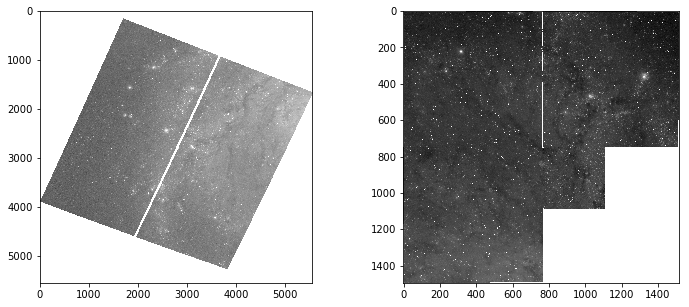

In [26]:
f, (ax1, ax2) = plt.subplots(1, 2)
f.set_figheight(5)
f.set_figwidth(12)
ax1.imshow(file1['SCI'].data, cmap="gray", norm=LogNorm(vmin=0.01, vmax=1))
ax2.imshow(file2['SCI'].data, cmap="gray", norm=LogNorm(vmin=0.01, vmax=1))